📊 ESTADÍSTICAS DE TUS DATASETS

📂 Analizando: TRAIN (processed_combined_teacher/combined_train.csv)
   ✅ Total de audios: 3931
   ⬇️  Distribución por emoción:
      - Neutro    : 1162 audios ( 29.6%)
      - Felicidad : 1083 audios ( 27.6%)
      - Tristeza  :  888 audios ( 22.6%)
      - Enojo     :  798 audios ( 20.3%)

📂 Analizando: VAL (processed_combined_teacher/combined_val.csv)
   ✅ Total de audios: 1031
   ⬇️  Distribución por emoción:
      - Enojo     :  327 audios ( 31.7%)
      - Felicidad :  303 audios ( 29.4%)
      - Neutro    :  258 audios ( 25.0%)
      - Tristeza  :  143 audios ( 13.9%)

📂 Analizando: TEST (processed_combined_teacher/combined_test.csv)
   ✅ Total de audios: 1241
   ⬇️  Distribución por emoción:
      - Felicidad :  442 audios ( 35.6%)
      - Neutro    :  384 audios ( 30.9%)
      - Tristeza  :  245 audios ( 19.7%)
      - Enojo     :  170 audios ( 13.7%)

📈 Gráfico guardado como: dataset_distribution.png


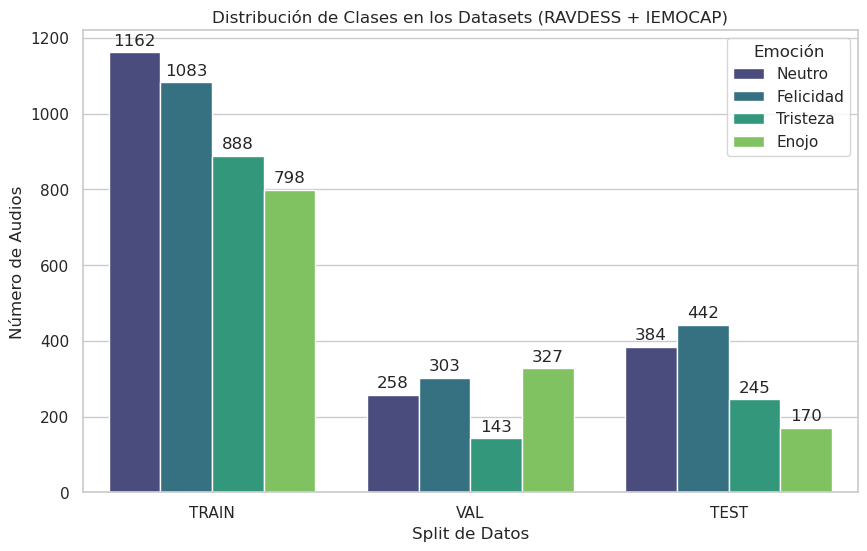

In [2]:
# =============================================================================
# SCRIPT: ESTADÍSTICAS DEL DATASET (CONTEO Y GRÁFICOS)
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. CONFIGURACIÓN
# Asegúrate de que esta carpeta sea la correcta donde tienes tus CSVs
DATA_DIR = Path("processed_combined_teacher") 

files = {
    "TRAIN": DATA_DIR / "combined_train.csv",
    "VAL":   DATA_DIR / "combined_val.csv",
    "TEST":  DATA_DIR / "combined_test.csv"
}

# Diccionario para mapear emociones (si las tienes en abreviatura)
label_map = {'ang': 'Enojo', 'hap': 'Felicidad', 'sad': 'Tristeza', 'neu': 'Neutro'}

# Lista para guardar datos y graficar después
all_data = []

print("="*60)
print("📊 ESTADÍSTICAS DE TUS DATASETS")
print("="*60)

for split_name, file_path in files.items():
    print(f"\n📂 Analizando: {split_name} ({file_path})")
    
    if not file_path.exists():
        print(f"   ❌ Error: No se encontró el archivo.")
        continue
        
    # Cargar CSV
    df = pd.read_csv(file_path)
    total = len(df)
    
    print(f"   ✅ Total de audios: {total}")
    print("   ⬇️  Distribución por emoción:")
    
    # Contar por emoción
    counts = df['emotion'].value_counts()
    
    for emotion, count in counts.items():
        emo_full = label_map.get(emotion, emotion)
        percentage = (count / total) * 100
        print(f"      - {emo_full:<10}: {count:>4} audios ({percentage:>5.1f}%)")
        
        # Guardar para el gráfico
        all_data.append({
            "Conjunto": split_name,
            "Emoción": emo_full,
            "Cantidad": count
        })
        
print("\n" + "="*60)

# -----------------------------------------------------------
# GENERAR GRÁFICO VISUAL
# -----------------------------------------------------------
if all_data:
    df_plot = pd.DataFrame(all_data)
    
    # Configurar estilo
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Crear gráfico de barras agrupado
    ax = sns.barplot(data=df_plot, x="Conjunto", y="Cantidad", hue="Emoción", palette="viridis")
    
    # Añadir números encima de las barras
    for container in ax.containers:
        ax.bar_label(container, padding=3)

    plt.title("Distribución de Clases en los Datasets (RAVDESS + IEMOCAP)")
    plt.ylabel("Número de Audios")
    plt.xlabel("Split de Datos")
    
    # Guardar imagen
    output_img = "dataset_distribution.png"
    plt.savefig(output_img, dpi=300)
    print(f"📈 Gráfico guardado como: {output_img}")
    print("="*60)

1. Cargando modelo fine-tuneado desde: wavlm_finetuned_balanced
2. Dataset de Test (Ses. 5) listo: 1241 muestras.
3. Ejecutando Inferencia en el conjunto de Test...


Testing IEMOCAP Ses. 5:   0%|          | 0/78 [00:00<?, ?it/s]


      ✅ RENDIMIENTO FINAL DEL MODELO EN IEMOCAP TEST (SESIÓN 5) ✅
🎯 Weighted Accuracy (WA): 0.5898
🏆 Unweighted Average Recall (UAR): 0.6298
------------------------------------------------------------


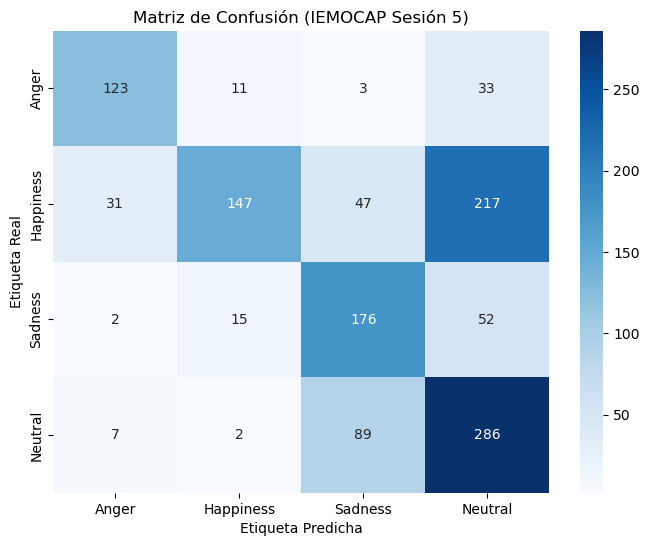

In [2]:
# =============================================================================
# SCRIPT 3: EVALUACIÓN FINAL EN IEMOCAP TEST (SESIÓN 5)
# =============================================================================

import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import librosa
import matplotlib.pyplot as plt
import seaborn as sns 
from transformers import WavLMForSequenceClassification, AutoFeatureExtractor

# ------------------------------------------------
# 1. CONFIGURACIÓN
# ------------------------------------------------
class TestConfig:
    # Ruta al CSV de test generado por el preprocesamiento
    TEST_CSV = "processed_iemocap/iemocap_test.csv"
    
    # RUTA AL MODELO GUARDADO POR EL TRAINER
    OUTPUT_DIR = Path("wavlm_finetuned_balanced") 
    
    BATCH_SIZE = 16
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SAMPLE_RATE = 16000
    
    # MAX_DURATION DEBE COINCIDIR CON EL ENTRENAMIENTO
    MAX_DURATION = 12.0 
    TARGET_LEN = int(SAMPLE_RATE * MAX_DURATION)
    
    # Mapeo de emociones
    IEMOCAP_TO_INDEX = {'ang': 0, 'hap': 1, 'sad': 2, 'neu': 3}
    CLASS_NAMES = ['Anger', 'Happiness', 'Sadness', 'Neutral'] 

cfg_test = TestConfig()

# ------------------------------------------------
# 2. CARGAR MODELO Y PROCESADOR
# ------------------------------------------------
print(f"1. Cargando modelo fine-tuneado desde: {cfg_test.OUTPUT_DIR}")
try:
    # El modelo y el procesador se cargan de la carpeta donde el Trainer guardó el mejor checkpoint.
    model = WavLMForSequenceClassification.from_pretrained(cfg_test.OUTPUT_DIR)
    processor = AutoFeatureExtractor.from_pretrained(cfg_test.OUTPUT_DIR)
    model.to(cfg_test.DEVICE)
    model.eval()
except Exception as e:
    print(f"❌ ERROR al cargar el modelo. ¿Terminó el entrenamiento y se guardó en {cfg_test.OUTPUT_DIR}?")
    print(f"Detalles: {e}")
    exit()

# ------------------------------------------------
# 3. DATASET Y DATALOADER DE TEST
# ------------------------------------------------
class IEMOCAPTestDataset(torch.utils.data.Dataset):
    def __init__(self, df, processor, config):
        self.df = df
        self.processor = processor
        self.config = config
        
    def __len__(self): return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y, sr = librosa.load(row['wav_path'], sr=self.config.SAMPLE_RATE)
        
        # Padding/Truncado
        if len(y) > self.config.TARGET_LEN: y = y[:self.config.TARGET_LEN]
        else: y = np.pad(y, (0, self.config.TARGET_LEN - len(y)), mode='constant')
            
        inputs = self.processor(y, sampling_rate=self.config.SAMPLE_RATE, return_tensors="pt")
        # Asegurarse de que el formato es correcto para el forward pass
        input_values = inputs.input_values.squeeze(0)
        
        label = cfg_test.IEMOCAP_TO_INDEX.get(row['emotion'])
        
        return {"input_values": input_values, "labels": torch.tensor(label, dtype=torch.long)}

try:
    test_df = pd.read_csv(cfg_test.TEST_CSV)
except FileNotFoundError:
    print(f"\n❌ ERROR: Archivo de test no encontrado: {cfg_test.TEST_CSV}.")
    exit()

test_dataset = IEMOCAPTestDataset(test_df, processor, cfg_test)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg_test.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)
print(f"2. Dataset de Test (Ses. 5) listo: {len(test_df)} muestras.")

# ------------------------------------------------
# 4. INFERENCIA Y RESULTADOS
# ------------------------------------------------
print("3. Ejecutando Inferencia en el conjunto de Test...")

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing IEMOCAP Ses. 5"):
        input_values = batch['input_values'].to(cfg_test.DEVICE)
        
        outputs = model(input_values)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# ------------------------------------------------
# 5. REPORTE FINAL
# ------------------------------------------------
WA = accuracy_score(all_labels, all_preds)
UAR = recall_score(all_labels, all_preds, average='macro')
cm = confusion_matrix(all_labels, all_preds)

print("\n" + "=" * 60)
print("      ✅ RENDIMIENTO FINAL DEL MODELO EN IEMOCAP TEST (SESIÓN 5) ✅")
print("=" * 60)
print(f"🎯 Weighted Accuracy (WA): {WA:.4f}")
print(f"🏆 Unweighted Average Recall (UAR): {UAR:.4f}")
print("-" * 60)

# --- VISUALIZACIÓN DE LA MATRIZ DE CONFUSIÓN ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', 
    xticklabels=cfg_test.CLASS_NAMES, 
    yticklabels=cfg_test.CLASS_NAMES
)
plt.title('Matriz de Confusión (IEMOCAP Sesión 5)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show() 

print("=" * 60)

Buscando archivo log en la nueva ruta: /workspace/notebooks/Carlos/Audio/wavlm_finetuned_balanced/checkpoint-1224/trainer_state.json


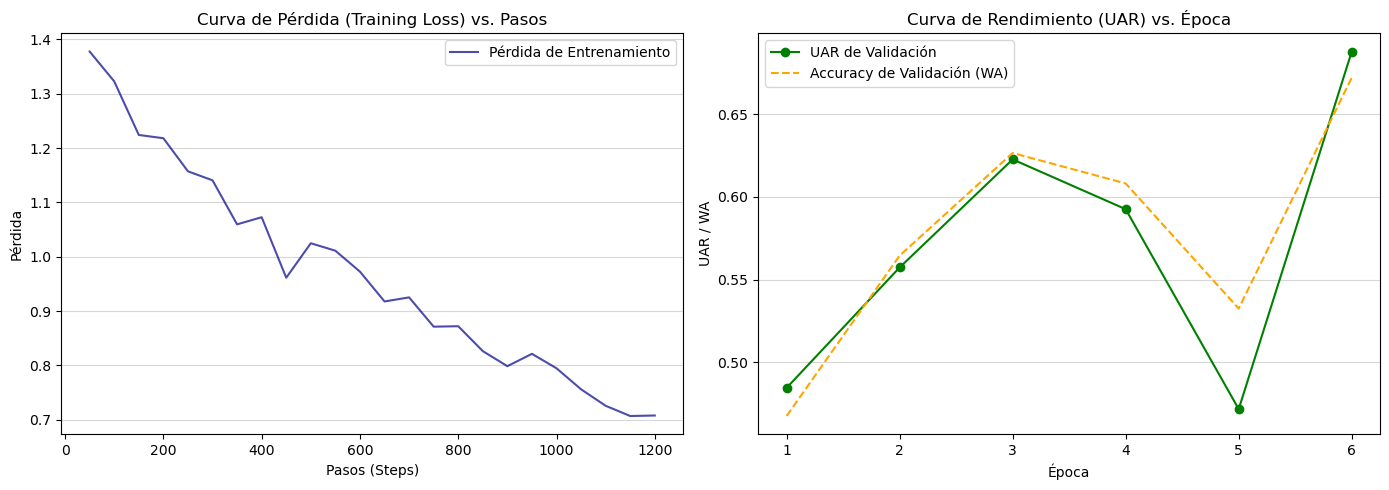


✅ Gráficas generadas exitosamente.


In [5]:
# =============================================================================
# CÓDIGO CORREGIDO PARA VISUALIZAR LAS CURVAS DE APRENDIZAJE
# =============================================================================

import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# 1. Configuración de la Ruta del Log
OUTPUT_DIR = Path("wavlm_finetuned_balanced")

# --- ¡CORRECCIÓN AQUÍ! ---
# Se asume que el log se movió al checkpoint más reciente o relevante.
# Busca el checkpoint más alto o el que esté listado.
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoint-1224" 
LOG_PATH = CHECKPOINT_DIR / "trainer_state.json"

print(f"Buscando archivo log en la nueva ruta: {LOG_PATH.resolve()}")

try:
    # 2. Cargar el Archivo Log
    with open(LOG_PATH, 'r') as f:
        log_history = json.load(f)['log_history']
        
    # Filtrar datos de entrenamiento y evaluación
    train_logs = [e for e in log_history if 'loss' in e and 'eval_loss' not in e]
    eval_logs = [e for e in log_history if 'eval_loss' in e]
    
    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    if eval_df.empty:
        print("\n❌ Advertencia: El historial de evaluación (Validation) está vacío o incompleto.")
        
    else:
        # 3. Gráfica de Pérdida (Loss)
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_df['step'], train_df['loss'], label='Pérdida de Entrenamiento', color='darkblue', alpha=0.7)
        plt.title('Curva de Pérdida (Training Loss) vs. Pasos')
        plt.xlabel('Pasos (Steps)')
        plt.ylabel('Pérdida')
        plt.grid(axis='y', alpha=0.5)
        plt.legend()

        # 4. Gráfica de Rendimiento (UAR)
        plt.subplot(1, 2, 2)
        
        plt.plot(eval_df['epoch'], eval_df['eval_uar'], label='UAR de Validación', color='green', marker='o')
        plt.plot(eval_df['epoch'], eval_df['eval_accuracy'], label='Accuracy de Validación (WA)', color='orange', linestyle='--')
        
        plt.title('Curva de Rendimiento (UAR) vs. Época')
        plt.xlabel('Época')
        plt.ylabel('UAR / WA')
        plt.grid(axis='y', alpha=0.5)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        
        print("\n✅ Gráficas generadas exitosamente.")

except FileNotFoundError:
    print(f"\n❌ ERROR: No se encontró el archivo log en la ruta corregida: {LOG_PATH}")
    print("Verifica que la carpeta 'checkpoint-1224' exista y contenga 'trainer_state.json'.")
except Exception as e:
    print(f"\n❌ ERROR inesperado: {e}")

In [1]:
#test de los combinado

In [2]:
# =============================================================================
# SCRIPT 3: EVALUACIÓN DEL MODELO (TEST SET + CONFUSION MATRIX)
# =============================================================================

import torch
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from transformers import WavLMForSequenceClassification, AutoFeatureExtractor, Trainer

# ------------------------------------------------
# 1. CONFIGURACIÓN
# ------------------------------------------------
class Config:
    # Ruta del archivo de TEST (Asegúrate de que este nombre sea correcto)
    TEST_CSV = "processed_combined_teacher/combined_test.csv" 
    
    # Ruta donde se guardó tu modelo entrenado
    MODEL_PATH = "wavlm_finetuned_multidomain_teacher"
    
    SAMPLE_RATE = 16000
    MAX_DURATION = 12.0
    TARGET_LEN = int(SAMPLE_RATE * MAX_DURATION)
    BATCH_SIZE = 8

cfg = Config()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------
# 2. DATASET (Misma clase que en el entrenamiento)
# ------------------------------------------------
class IEMOCAPDataset(torch.utils.data.Dataset):
    def __init__(self, df, processor, config):
        self.df = df
        self.processor = processor
        self.config = config
        self.label_map = {'ang': 0, 'hap': 1, 'sad': 2, 'neu': 3}

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav_path = row['wav_path']

        # Cargar audio y ajustar longitud
        y, sr = librosa.load(wav_path, sr=self.config.SAMPLE_RATE)
        if len(y) > self.config.TARGET_LEN: 
            y = y[:self.config.TARGET_LEN]
        else: 
            y = np.pad(y, (0, self.config.TARGET_LEN - len(y)), mode='constant')

        inputs = self.processor(y, sampling_rate=self.config.SAMPLE_RATE, return_tensors="pt")
        input_values = inputs.input_values.squeeze(0).numpy()
        
        label = self.label_map.get(row['emotion'], 3)
        return {"input_values": input_values, "labels": label}

# ------------------------------------------------
# 3. CARGA DE MODELO Y DATOS
# ------------------------------------------------
print(f"📂 Cargando modelo desde: {cfg.MODEL_PATH}...")
try:
    model = WavLMForSequenceClassification.from_pretrained(cfg.MODEL_PATH)
    processor = AutoFeatureExtractor.from_pretrained(cfg.MODEL_PATH)
    model.to(DEVICE)
    model.eval() # Modo evaluación
except OSError:
    print("❌ Error: No se encuentra el modelo. Ejecuta el entrenamiento primero.")
    exit()

print(f"📂 Cargando datos de Test desde: {cfg.TEST_CSV}...")
try:
    test_df = pd.read_csv(cfg.TEST_CSV)
except FileNotFoundError:
    print(f"❌ Error: No se encuentra {cfg.TEST_CSV}. Verifica la ruta.")
    exit()

test_dataset = IEMOCAPDataset(test_df, processor, cfg)

# ------------------------------------------------
# 4. INFERENCIA
# ------------------------------------------------
print("🚀 Iniciando inferencia en el conjunto de Test...")

# Usamos el Trainer solo para predecir (más rápido que un bucle manual)
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)

# Obtener las clases predichas (argmax de los logits)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# ------------------------------------------------
# 5. CÁLCULO DE MÉTRICAS
# ------------------------------------------------
acc = accuracy_score(labels, preds)
uar = recall_score(labels, preds, average='macro')

print("\n" + "="*40)
print("📊 RESULTADOS DEL TEST")
print("="*40)
print(f"✅ Accuracy (Exactitud): {acc:.4f}")
print(f"✅ UAR (Recall Promedio): {uar:.4f}")
print("-" * 40)

# Reporte detallado por clase
label_names = ['Anger', 'Happiness', 'Sadness', 'Neutral']
print("\n📋 Reporte de Clasificación:")
print(classification_report(labels, preds, target_names=label_names, digits=4))

# ------------------------------------------------
# 6. MATRIZ DE CONFUSIÓN (Guardar imagen)
# ------------------------------------------------
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicción')
plt.ylabel('Realidad (Ground Truth)')
plt.title(f'Matriz de Confusión\nAcc: {acc:.2f} | UAR: {uar:.2f}')

output_img = "confusion_matrix_test.png"
plt.savefig(output_img)
print(f"\n💾 Matriz de confusión guardada como: {output_img}")
plt.close()

📂 Cargando modelo desde: wavlm_finetuned_multidomain_teacher...


comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key


📂 Cargando datos de Test desde: processed_combined_teacher/combined_test.csv...
🚀 Iniciando inferencia en el conjunto de Test...


/root/miniconda3/envs/audio_edge_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 RESULTADOS DEL TEST
✅ Accuracy (Exactitud): 0.6519
✅ UAR (Recall Promedio): 0.6703
----------------------------------------

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       Anger     0.6041    0.8706    0.7133       170
   Happiness     0.6610    0.7014    0.6806       442
     Sadness     0.6875    0.5388    0.6041       245
     Neutral     0.6537    0.5703    0.6092       384

    accuracy                         0.6519      1241
   macro avg     0.6516    0.6703    0.6518      1241
weighted avg     0.6562    0.6519    0.6479      1241


💾 Matriz de confusión guardada como: confusion_matrix_test.png


In [ ]:
# =============================================================================
# SCRIPT DE INFERENCIA: PRUEBA TU MEJOR MODELO (TEACHER)
# =============================================================================

import torch
import torch.nn.functional as F
import librosa
import numpy as np
from transformers import WavLMForSequenceClassification, AutoFeatureExtractor
import os

class EmotionPredictor:
    def __init__(self, model_path):
        # Configuración del dispositivo (GPU si hay, sino CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"📂 Cargando modelo ganador desde: {model_path}...")
        
        try:
            self.processor = AutoFeatureExtractor.from_pretrained(model_path)
            self.model = WavLMForSequenceClassification.from_pretrained(model_path)
            self.model.to(self.device)
            self.model.eval() # Importante: Poner en modo evaluación
            print("✅ Modelo cargado y listo en", self.device)
        except Exception as e:
            print(f"❌ Error crítico cargando el modelo: {e}")
            print("Asegúrate de que la carpeta existe y tiene los archivos .bin y config.json")
            exit()
            
        # Etiquetas (Mapeo: 'ang': 0, 'hap': 1, 'sad': 2, 'neu': 3)
        self.labels = ['😡 Enojo (Anger)', '😄 Felicidad (Happiness)', '😢 Tristeza (Sadness)', '😐 Neutro (Neutral)']

    def predict(self, audio_path):
        # 1. Validar archivo
        if not os.path.exists(audio_path):
            return f"❌ El archivo no existe: {audio_path}"

        # 2. Cargar Audio y Resamplear a 16kHz (WavLM lo exige)
        target_sr = 16000
        try:
            y, sr = librosa.load(audio_path, sr=target_sr)
        except Exception as e:
            return f"❌ Error leyendo audio: {e}"

        # 3. Pre-procesamiento (Cortar si es muy largo, WavLM maneja bien hasta ~10-15s)
        max_len = target_sr * 10 # 10 segundos
        if len(y) > max_len:
            y = y[:max_len]
            
        # 4. Preparar Tensores
        inputs = self.processor(y, sampling_rate=target_sr, return_tensors="pt")
        # Mover inputs a la GPU si está disponible
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # 5. Inferencia (Sin calcular gradientes)
        with torch.no_grad():
            logits = self.model(**inputs).logits
        
        # 6. Calcular Probabilidades (Softmax)
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]
        
        # 7. Obtener la clase ganadora
        pred_idx = np.argmax(probs)
        confidence = probs[pred_idx]
        
        return {
            "label": self.labels[pred_idx],
            "confidence": confidence,
            "all_probs": probs
        }

# -----------------------------------------------------------
# ZONA DE EJECUCIÓN
# -----------------------------------------------------------
if __name__ == "__main__":
    # RUTA A TU MEJOR MODELO (Asegúrate que coincide con tu carpeta)
    BEST_MODEL_DIR = "wavlm_finetuned_multidomain_teacher"
    
    predictor = EmotionPredictor(BEST_MODEL_DIR)
    
    print("\n" + "="*50)
    print("🤖 INTERFAZ DE PRUEBA DE EMOCIONES")
    print("="*50)
    
    while True:
        path = input("\n📝 Ingresa la ruta del archivo .wav (o 'q' para salir): ").strip().strip("'").strip('"')
        
        if path.lower() == 'q':
            break
            
        if not path:
            continue
            
        result = predictor.predict(path)
        
        if isinstance(result, dict):
            print(f"\n🔮 PREDICCIÓN: {result['label']}")
            print(f"📊 Confianza:  {result['confidence']:.2%}")
            print("-" * 30)
            print("Detalle:")
            for i, prob in enumerate(result['all_probs']):
                bar = "█" * int(prob * 20)
                print(f"  {predictor.labels[i]:<25} : {prob:.4f} {bar}")
        else:
            print(result)

📂 Cargando modelo ganador desde: wavlm_finetuned_multidomain_teacher...
✅ Modelo cargado y listo en cuda

🤖 INTERFAZ DE PRUEBA DE EMOCIONES

📝 Ingresa la ruta del archivo .wav (o 'q' para salir): processed_iemocap/hap/Ses04M_impro03_M019.wav

🔮 PREDICCIÓN: 😄 Felicidad (Happiness)
📊 Confianza:  73.06%
------------------------------
Detalle:
  😡 Enojo (Anger)           : 0.0763 █
  😄 Felicidad (Happiness)   : 0.7306 ██████████████
  😢 Tristeza (Sadness)      : 0.0694 █
  😐 Neutro (Neutral)        : 0.1238 ██


/root/miniconda3/envs/audio_edge_env/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [3]:
# =============================================================================
# SCRIPT 3B: EVALUACIÓN DE HuBERT BASE (TEST SET + CONFUSION MATRIX)
# =============================================================================

import torch
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from transformers import HubertForSequenceClassification, AutoFeatureExtractor, Trainer

# ------------------------------------------------
# 1. CONFIGURACIÓN
# ------------------------------------------------
class Config:
    # Ruta del archivo de TEST
    TEST_CSV = "processed_combined_teacher/combined_test.csv" 
    
    # RUTA A TU MAESTRO HuBERT (Asegúrate que coincida con tu output anterior)
    MODEL_PATH = "teacher_hubert_base_v2_deep"
    
    SAMPLE_RATE = 16000
    MAX_DURATION = 10.0 # HuBERT usó 10s en el entrenamiento
    TARGET_LEN = int(SAMPLE_RATE * MAX_DURATION)
    BATCH_SIZE = 8

cfg = Config()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------
# 2. DATASET
# ------------------------------------------------
class IEMOCAPDataset(torch.utils.data.Dataset):
    def __init__(self, df, processor, config):
        self.df = df
        self.processor = processor
        self.config = config
        self.label_map = {'ang': 0, 'hap': 1, 'sad': 2, 'neu': 3}

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav_path = row['wav_path']

        # Cargar audio y ajustar longitud
        try:
            y, sr = librosa.load(wav_path, sr=self.config.SAMPLE_RATE)
        except Exception as e:
            print(f"Error en {wav_path}: {e}")
            y = np.zeros(self.config.TARGET_LEN)

        if len(y) > self.config.TARGET_LEN: 
            y = y[:self.config.TARGET_LEN]
        else: 
            y = np.pad(y, (0, self.config.TARGET_LEN - len(y)), mode='constant')

        inputs = self.processor(y, sampling_rate=self.config.SAMPLE_RATE, return_tensors="pt")
        input_values = inputs.input_values.squeeze(0).numpy()
        
        label = self.label_map.get(row['emotion'], 3)
        return {"input_values": input_values, "labels": label}

# ------------------------------------------------
# 3. CARGA DE MODELO Y DATOS
# ------------------------------------------------
print(f"📂 Cargando modelo HuBERT desde: {cfg.MODEL_PATH}...")
try:
    # CAMBIO IMPORTANTE: Usamos la clase de HuBERT
    model = HubertForSequenceClassification.from_pretrained(cfg.MODEL_PATH)
    processor = AutoFeatureExtractor.from_pretrained(cfg.MODEL_PATH)
    model.to(DEVICE)
    model.eval()
except OSError:
    print("❌ Error: No se encuentra el modelo. Verifica la ruta en Config.")
    exit()

print(f"📂 Cargando datos de Test desde: {cfg.TEST_CSV}...")
try:
    test_df = pd.read_csv(cfg.TEST_CSV)
except FileNotFoundError:
    print(f"❌ Error: No se encuentra {cfg.TEST_CSV}.")
    exit()

test_dataset = IEMOCAPDataset(test_df, processor, cfg)

# ------------------------------------------------
# 4. INFERENCIA
# ------------------------------------------------
print("🚀 Iniciando inferencia con HuBERT Base...")

trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# ------------------------------------------------
# 5. CÁLCULO DE MÉTRICAS
# ------------------------------------------------
acc = accuracy_score(labels, preds)
uar = recall_score(labels, preds, average='macro')

print("\n" + "="*40)
print("📊 RESULTADOS DEL TEST (HuBERT BASE)")
print("="*40)
print(f"✅ Accuracy (Exactitud): {acc:.4f}")
print(f"✅ UAR (Recall Promedio): {uar:.4f}")
print("-" * 40)

label_names = ['Anger', 'Happiness', 'Sadness', 'Neutral']
print("\n📋 Reporte de Clasificación:")
print(classification_report(labels, preds, target_names=label_names, digits=4))

# ------------------------------------------------
# 6. MATRIZ DE CONFUSIÓN
# ------------------------------------------------
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # Usamos verde para diferenciar de WavLM
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title(f'Matriz de Confusión (HuBERT Base)\nAcc: {acc:.2f} | UAR: {uar:.2f}')

output_img = "confusion_matrix_hubert_base.png"
plt.savefig(output_img)
print(f"\n💾 Matriz de confusión guardada como: {output_img}")
plt.close()

comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key


📂 Cargando modelo HuBERT desde: Huber-base-v1...
📂 Cargando datos de Test desde: processed_combined_teacher/combined_test.csv...
🚀 Iniciando inferencia con HuBERT Base...


/root/miniconda3/envs/audio_edge_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 RESULTADOS DEL TEST (HuBERT BASE)
✅ Accuracy (Exactitud): 0.5898
✅ UAR (Recall Promedio): 0.6181
----------------------------------------

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       Anger     0.7211    0.6235    0.6688       170
   Happiness     0.6700    0.4502    0.5386       442
     Sadness     0.5286    0.7918    0.6340       245
     Neutral     0.5419    0.6068    0.5725       384

    accuracy                         0.5898      1241
   macro avg     0.6154    0.6181    0.6035      1241
weighted avg     0.6094    0.5898    0.5857      1241


💾 Matriz de confusión guardada como: confusion_matrix_hubert_base.png


In [6]:
import pandas as pd
import json
import os

# --- 1. INSPECCIONAR DATOS (CSV) ---
csv_path = "processed_combined_teacher/combined_test.csv"
print(f"📂 Analizando CSV: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"   -> Filas totales: {len(df)}")
    print(f"   -> Columnas encontradas: {list(df.columns)}")
    
    # Revisar columna de etiquetas (probamos 'emotion' o 'label')
    target_col = 'emotion' if 'emotion' in df.columns else 'label'
    
    if target_col in df.columns:
        unique_vals = df[target_col].unique()
        print(f"   -> Etiquetas únicas en '{target_col}': {unique_vals}")
        print(f"   -> ¿Hay valores nulos? {df[target_col].isna().sum()}")
    else:
        print("   ❌ NO se encontró columna 'emotion' ni 'label'.")

except Exception as e:
    print(f"   ❌ Error leyendo CSV: {e}")

# --- 2. INSPECCIONAR MODELO (Config.json) ---
model_config_path = "teacher_whisper_medium/config.json"
print(f"\n📂 Analizando Config del Modelo: {model_config_path}")

try:
    with open(model_config_path, "r") as f:
        cfg = json.load(f)
        print(f"   -> Arquitectura: {cfg.get('architectures')}")
        print(f"   -> num_labels: {cfg.get('num_labels')}")
        print(f"   -> id2label: {cfg.get('id2label')}")
except FileNotFoundError:
    print("   ❌ NO se encontró el archivo config.json en la carpeta del modelo.")
except Exception as e:
    print(f"   ❌ Error leyendo Config: {e}")

📂 Analizando CSV: processed_combined_teacher/combined_test.csv
   -> Filas totales: 1241
   -> Columnas encontradas: ['wav_path', 'emotion', 'speaker', 'session']
   -> Etiquetas únicas en 'emotion': ['neu' 'ang' 'sad' 'hap']
   -> ¿Hay valores nulos? 0

📂 Analizando Config del Modelo: teacher_whisper_medium/config.json
   -> Arquitectura: ['WhisperModel']
   -> num_labels: None
   -> id2label: None


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at teacher_whisper_medium and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Usando dispositivo: cuda
📂 Cargando cuerpo de Whisper desde: teacher_whisper_medium...
💉 Inyectando pesos de clasificación desde: teacher_whisper_medium/classifier.pt
   -> Claves cargadas correctamente.
   -> Missing keys (debería ser todo el encoder de whisper): 371
   -> Unexpected keys: ['weight', 'bias']


comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key


🚀 Iniciando inferencia en Test Set...


/root/miniconda3/envs/audio_edge_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 RESULTADOS REALES (Whisper Medium)
✅ Accuracy: 0.1531
✅ UAR: 0.2577
💾 Matriz guardada.


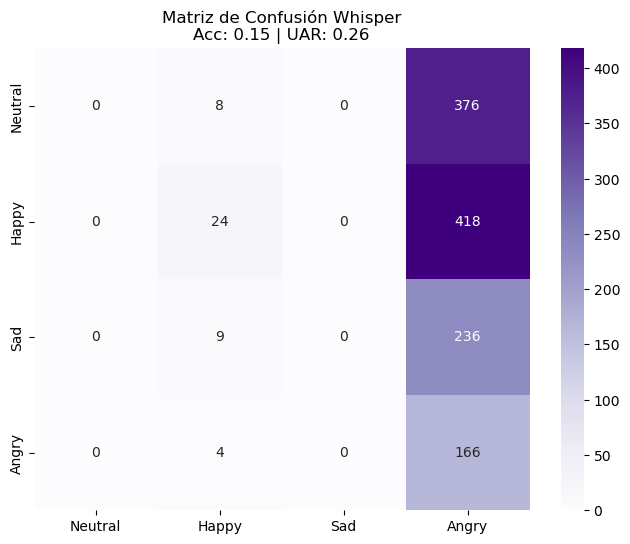

In [1]:
import torch
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor, Trainer

# ------------------------------------------------
# 1. CONFIGURACIÓN
# ------------------------------------------------
class Config:
    TEST_CSV = "processed_combined_teacher/combined_test.csv"
    MODEL_DIR = "teacher_whisper_medium"
    # Ruta específica a la cabeza de clasificación
    CLASSIFIER_PATH = f"{MODEL_DIR}/classifier.pt" 
    
    BATCH_SIZE = 8
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = Config()
print(f"🚀 Usando dispositivo: {cfg.DEVICE}")

# ------------------------------------------------
# 2. DATASET
# ------------------------------------------------
class WhisperEvalDataset(torch.utils.data.Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor
        self.label_map = {
            'neu': 0, 'neutral': 0,
            'hap': 1, 'happy': 1,
            'sad': 2, 'sadness': 2,
            'ang': 3, 'angry': 3
        }

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav_path = row['wav_path'] 
        try:
            y, sr = librosa.load(wav_path, sr=16000)
        except Exception:
            y = np.zeros(16000)

        inputs = self.processor(y, sampling_rate=16000, return_tensors="pt")
        input_features = inputs.input_features.squeeze(0).numpy()
        
        label_str = row['emotion']
        label = self.label_map.get(str(label_str).lower().strip(), 0)

        return {"input_features": input_features, "labels": label}

# ------------------------------------------------
# 3. CARGA DE MODELO + INYECCIÓN DE PESOS (LA SOLUCIÓN)
# ------------------------------------------------
print(f"📂 Cargando cuerpo de Whisper desde: {cfg.MODEL_DIR}...")

try:
    processor = AutoFeatureExtractor.from_pretrained(cfg.MODEL_DIR)
    
    # A. Inicializamos la arquitectura base forzando 4 clases
    model = AutoModelForAudioClassification.from_pretrained(
        cfg.MODEL_DIR,
        num_labels=4,
        ignore_mismatched_sizes=True
    )
    
    # B. CARGA MANUAL DE LA CABEZA (classifier.pt)
    print(f"💉 Inyectando pesos de clasificación desde: {cfg.CLASSIFIER_PATH}")
    
    # Cargamos el diccionario de estados del archivo .pt
    classifier_state_dict = torch.load(cfg.CLASSIFIER_PATH, map_location='cpu')
    
    # Imprimimos las claves para debug (por si tienen prefijos raros)
    # print("Claves encontradas en classifier.pt:", classifier_state_dict.keys())
    
    # Intentamos cargar los pesos. 
    # A veces se guardan como modelo completo o solo state_dict.
    # Asumimos que es state_dict de la capa final.
    
    # Opción 1: Si classifier.pt tiene claves como 'classifier.weight', 'projector.weight'
    missing_keys, unexpected_keys = model.load_state_dict(classifier_state_dict, strict=False)
    
    print(f"   -> Claves cargadas correctamente.")
    print(f"   -> Missing keys (debería ser todo el encoder de whisper): {len(missing_keys)}")
    print(f"   -> Unexpected keys: {unexpected_keys}")
    
    model.to(cfg.DEVICE)
    model.eval()
    
except Exception as e:
    print(f"❌ Error cargando modelo: {e}")
    # Si falla aquí, es probable que la estructura de classifier.pt sea diferente.
    # Avísame si sale error para ajustar la lógica de carga.
    exit()

# ------------------------------------------------
# 4. INFERENCIA
# ------------------------------------------------
print("🚀 Iniciando inferencia en Test Set...")
df = pd.read_csv(cfg.TEST_CSV)
test_dataset = WhisperEvalDataset(df, processor)

trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# ------------------------------------------------
# 5. RESULTADOS
# ------------------------------------------------
acc = accuracy_score(labels, preds)
uar = recall_score(labels, preds, average='macro')

print("\n" + "="*40)
print(f"📊 RESULTADOS REALES (Whisper Medium)")
print("="*40)
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ UAR: {uar:.4f}")

# Guardar Matriz
label_names = ['Neutral', 'Happy', 'Sad', 'Angry']
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=label_names, yticklabels=label_names)
plt.title(f'Matriz de Confusión Whisper\nAcc: {acc:.2f} | UAR: {uar:.2f}')
plt.savefig("confusion_matrix_whisper_final.png")
print("💾 Matriz guardada.")